## Heilbrigðislíkan
Smá byrjun

In [2]:
import simpy as sp
import streamlit as st
import numpy as np
import math
import random
import time
import os
import signal
from multiprocessing import Process
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
TIMI = 0
STOP = 10000
visual_col,chart_col = st.columns([1,3])
prob = {
    "surgery" : (0.0,0.7,0.3,0.0),
    "móttaka" : (0.5,0.0,0.0,0.5),
    "death" : (0.0,0.0,1.0,0.0),
    "Heim" : (0.0,0.0,0.0,1.0)
}

In [13]:
class Patient:
    def __init__(self,aldur,place):
        self.aldur = aldur
        self.place = place
        if self.place == "skurðaaðgerð":
            self.p_death = 0.1
            self.p_surgery = 0.0
            self.p_mottaka = 0.9
        if self.place == "móttaka":
            self.p_death = 0.0
            self.p_surgery = 0.3
            self.p_home = 0.7

class Spitali:
    def __init__(self,cap,amount):
        self.cap = cap
        self.amount = amount
    def addP(self):
        #if self.amount == self.cap:
            #raise Exception("Nú er spítalinn fullur það tók")
        self.amount += 1
    def removeP(self):
        self.amount -= 1

In [14]:
#sliders o.fl.
with st.expander("Breyta hlutum"):
    h_A = st.slider("Hlutfall aldraðra",value = 0.3,step = 0.02)
    N = st.slider("Stærð þjóðar",min_value = 500,max_value = 5000,value = 1000,step = 100)
    T = st.slider("Tímaskref í dögum",min_value = 1,max_value = 30,step = 1)
    CAP = st.slider("Hámarskfjöldi á spítala",min_value = 100,max_value = 1000,value = 250,step = 50)
    PROB_A = st.slider("Líkur á að aldraðir fari á spítala",value = 0.1,step=0.1)
    PROB_U = st.slider("Líkur á að ungir fari á spítala",value = 0.02,step=0.1)

h_U = 1-h_A

2023-05-25 10:59:11.629 Session state does not function when running a script without `streamlit run`


DeltaGenerator()

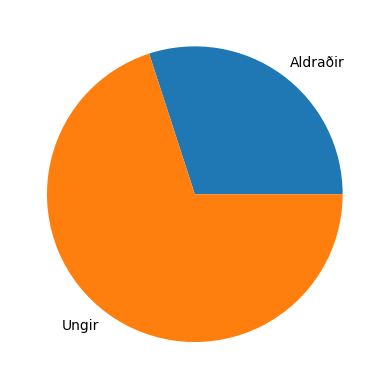

In [7]:
labels = "Aldraðir","Ungir"
sizes = [h_A*N,h_U*N]

fig1,ax1 = plt.subplots()
ax1.pie(sizes,labels = labels)

visual_col.pyplot(fig1)

In [18]:
def sim():
    p_A = PROB_A
    p_U = PROB_U
    n = N
    timi = TIMI
    t = T
    cap = CAP
    P = []            # fjöldi sjúklinga á spítala
    S = Spitali(cap,0)  # spítali með capacity 500 og núverandi sjúklinga 0
    d = {"fjöldi á spítala":[0],"capacity":cap}
    df = pd.DataFrame(d,index = [timi])
    chart = chart_col.line_chart(df)
    while(timi < STOP):
        timi += t
        s_A = t*np.random.binomial(h_A*n,p_A)
        s_U = t*np.random.binomial(h_U*n,p_U)
        n -= (s_A+s_U)
        for _ in range(s_A):
            age = random.randint(65,99)
            pi = Patient(age,"móttaka")
            P.append(pi)
            S.addP()
        for _ in range(s_U):
            age = random.randint(1,64)
            pi = Patient(age,"móttaka")
            P.append(pi)
            S.addP()
        for p in P:
            r = random.random()
            if p.place == "móttaka":
                if r < p.p_death:
                    P.remove(p)
                    S.removeP()
                if r >= p.p_death and r <= p.p_surgery:
                    P.remove(p)
                    S.removeP()
                    n += 1
                else:
                    p.place = "skurðaaðgerð"
            elif p.place == "skurðaaðgerð":
                if r < p.p_surgery:
                    p.place = "skurðaaðgerð"
                if r >= p.p_surgery and r <= p.p_death:
                    P.remove(p)
                    S.removeP()
                else:
                    p.place = "móttaka"
        d = {"fjöldi á spítala": [S.amount],"capacity":cap}
        df = pd.DataFrame(d,index = [timi])
        chart.add_rows(df)
        time.sleep(0.1)
        print("fjöldi fólks á spítala á degi",timi,"er",S.amount)

In [19]:
st.sidebar.title("Controls")
start = st.sidebar.button("Start")
stop = st.sidebar.button("Stop")

if start:
    sim()

if stop:
    st.stop()